The objective of this notebook is to compare the behaviour of a microscopic model with the solution of a PDE which should correspond to its macroscopic limit.

***Microscopic model***

*Movement.* We assume that each mosquito follows an Itô diffusion process without drift. At the beginning of the release experiment, there are $N_0$ mosquitoes, and their positions $X_t^k \in \mathbb{R}$ at time $t$ are governed by the following stochastic differential equation:
$$dX_t^k = \sigma(X_t^k) dB_t, \quad X_0^k = 0,$$
where $B$ is a 1-dimensional Brownian motion, and $\sigma$ is a Lipschitz-continuous function on $\mathbb{R}$ that describes the local mosquito mobility, which may vary depending on local conditions.

*Life expectancy and death times.* In the absence of trapping, the mosquito's life expectancy is given by $1/\nu>0$. Their death times follow an exponential distribution with parameter $\nu$.

*Trapping.* A trap is located at a position $x_0 \in \mathbb{R}$. For a mosquito with position $X_t$, the probability of being trapped follows an exponential distribution with parameter $f(X_t)=\gamma \, \exp(-\|X_t-x_0\|^2/R^2)$.  This implies that the average duration before capture at position $x$ is $1/f(x)$. The constant $R > 0$ measures the rate at which the trap loses its effectiveness as one moves farther away from $x_0$.

***Macroscopic model***
The expected mosquito population density $h(t,x)$ is the solution to the following equation:
$$
		\left\{
		\begin{array}{rl}
			\frac{\partial h}{\partial t} & =  \Delta\left(\frac{\sigma(x)^2}{2} h\right) - \nu \, h -  h  f(x), \quad t>0, \quad x\in \mathbb{R}^2, \\
			h(0,x) & =  N_0 \, \delta_{x=x_0}.
		\end{array}\right.
$$

# 1D Microscopic and macroscopic models

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from IPython.display import FileLink
import sympy as sp
from sympy import exp
from scipy.integrate import odeint
import matplotlib.pyplot as plt


# ---------------------------
# 1. Global Parameters
# ---------------------------
N0 = 10000        # initial number of mosquitoes
T_max = 10.0        # total simulation time
dt = 0.005         # time step for the microscopic model
num_steps = int(T_max / dt)

nu = 0.1           # death rate
gamma = 1/2        # trapping rate constant
x0 = 20.0          # trap position
R = 10.0           # decay scale in the exponential
sigma1 = 25.0      # diffusion coefficient
sigma2 = 20.0      # diffusion coefficient




x_max = 500.0      # domain for plotting/histograms


# ---------------------------
# 2. Microscopic Model
# ---------------------------
# Define the function sigma(x)
def sigma(x):
    return sigma1 + (sigma2 - sigma1) * (1 + np.tanh(x + 20))/2

# Define the trapping rate f(x) = gamma * exp(-((x - x0)^2)/R^2)
def f(x):
    return gamma * np.exp(-(x - x0)**2 / (R**2))


# Initialize arrays
positions = np.zeros(N0)         # all mosquitoes start at x=0
alive = np.ones(N0, dtype=bool)  # all are initially alive

trapped_microscopic = np.zeros(num_steps + 1)  # cumulative trapped at each step
t_array = np.zeros(num_steps + 1)              # time array for microscopic
t_array[0] = 0.0

# For histogram / animation
dx_hist = 2.0
grid_edges = np.arange(-x_max, x_max + dx_hist, dx_hist)
grid_centers = 0.5 * (grid_edges[:-1] + grid_edges[1:])

# We store snapshots of positions (only those alive) for animation
save_positions = []
time_points = []

# Main microscopic loop
t = 0.0
for step in range(num_steps):
    t += dt
    t_array[step + 1] = t

    # Brownian update
    idx_alive = np.where(alive)[0]
    Z = np.random.randn(len(idx_alive))
    positions[idx_alive] += sigma(positions[idx_alive]) * np.sqrt(dt) * Z

    # Death events
    die_events = (np.random.rand(len(idx_alive)) < nu * dt)
    alive[idx_alive[die_events]] = False

    # Trapping events
    idx_alive = np.where(alive)[0]
    trap_probs = f(positions[idx_alive]) * dt
    trap_events = (np.random.rand(len(idx_alive)) < trap_probs)
    newly_trapped = np.sum(trap_events)
    alive[idx_alive[trap_events]] = False

    # Update cumulative number trapped
    trapped_microscopic[step + 1] = trapped_microscopic[step] + newly_trapped

    # Save positions for animation every 10 steps (optional)
    if step % 10 == 0:
        save_positions.append(positions[alive].copy())
        time_points.append(t)

# ---------------------------
# 3. PDE Model
# ---------------------------

# Define symbolic variables
t_sym, x_sym, u_sym, rho_sym = sp.symbols('t x u rho', real=True)

# PDE source term: F = -nu*u - gamma*exp(...)*u
fun_F_sym = -nu * u_sym - gamma * sp.exp(-((x_sym - x0)**2) / (R**2)) * u_sym

# Diffusion coefficient:
fun_D_sym = (sigma1 + (sigma2 - sigma1) * (1 + sp.tanh(x_sym + 20))/2) ** 2 /2

# Convert to numeric functions (though F also depends on the solution u, so we keep the signature (t,x,u,rho))
num_F = sp.lambdify((t_sym, x_sym, u_sym, rho_sym), fun_F_sym, 'numpy')
num_D = sp.lambdify((t_sym, x_sym), fun_D_sym, 'numpy')

def sol_RD_1D(times, fun_D, fun_F, N0, BC="Neumann"):
    """
    Solve PDE:
      dU/dt = D(x,t) d^2U/dx^2 + F(x,t,U,RHO)
    on x in [-x_max, x_max], with a 'delta-like' initial condition.
    """
    xmax = x_max
    xmin = -x_max
    nx = 400
    LX = xmax - xmin
    dx = LX / nx
    xx = np.linspace(xmin + dx/2, xmax - dx/2, nx)  # centers

    # Create initial condition: place all mass at x=0
    U0 = np.zeros(nx)
    idx_zero = np.argmin(np.abs(xx))  # index closest to x=0
    U0[idx_zero] = N0 / dx

    # Build discrete Laplacian with chosen BC
    # We'll store it in matrix A
    dA = np.ones(nx - 1)
    A = np.diag(dA, -1) - 2 * np.eye(nx) + np.diag(dA, 1)
    if BC == "Neumann":
        A[0, 0] = -1
        A[-1, -1] = -1
    elif BC == "Dirichlet":
        A[0, :] = 0
        A[-1, :] = 0
    A = A / (dx**2)

    def dynlattice(U, t_):
        # RHO = total integral of U * dx
        RHO = np.sum(U) * dx
        VF = fun_F(t_, xx, U, RHO)  # reaction/trapping term
        MD = fun_D(t_, xx)         # diffusion coefficient
        return A.dot(MD * U) + VF

    Y = odeint(dynlattice, U0, times)
    return Y, xx, times

# Solve PDE on the same T range
times = np.linspace(0, T_max, num_steps)
numerical_solution, xx, times = sol_RD_1D(times, num_D, num_F, N0, BC="Neumann")

# ---------------------------
# 4. Track Trapped in PDE
# ---------------------------
# The PDE lost mass due to:
#   - Death:   integral( nu * U )
#   - Trapping integral( gamma * exp(...) * U )
# We'll focus on the "trap" contribution:
#   TrapRate(t) = gamma * int( exp(...) * U(t,x) dx )
# Then cumulative trap is the time integral of that rate.

dx_pde = xx[1] - xx[0]
trapped_pde = np.zeros(len(times))

for i in range(1, len(times)):
    dt_ = times[i] - times[i - 1]

    # PDE solution at i-1 (for forward Euler; or use trapezoidal rule if desired)
    U_here = numerical_solution[i - 1, :]
    trap_rate = np.sum(gamma * np.exp(-((xx - x0)**2) / (R**2)) * U_here) * dx_pde

    trapped_pde[i] = trapped_pde[i - 1] + trap_rate * dt_




# Comparison at successive times

Figure saved to /content/plot_1D.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

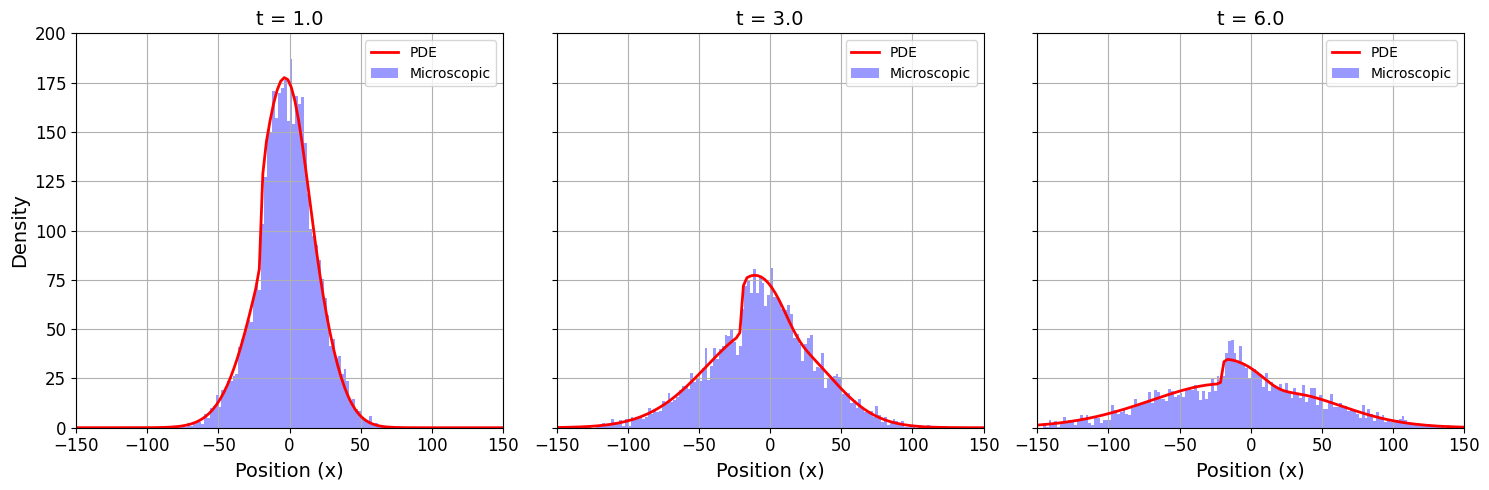

In [2]:

# 1) Choose the times of interest
times_of_interest = [1.0, 3.0, 6.0]

# 2) Prepare a figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

time_points = np.array(time_points)  # Ensure time_points is a NumPy array

# Helper function to find the closest index
def find_closest_index(array, value):
    return np.argmin(np.abs(array - value))

for i, ttarget in enumerate(times_of_interest):
    # --- Microscopic data ---
    i_micro = find_closest_index(time_points, ttarget)
    data = save_positions[i_micro]
    counts, _ = np.histogram(data, bins=grid_edges)
    density_brownian = counts / dx_hist

    # --- PDE data ---
    i_pde = find_closest_index(times, ttarget)
    U_pde = numerical_solution[i_pde, :]

    # --- Plot on axes[i] ---
    ax = axes[i]

    # Microscopic histogram as a bar plot
    ax.bar(
        grid_centers,
        density_brownian,
        width=dx_hist,
        alpha=0.4,
        color='blue',
        label='Microscopic'
    )

    # PDE solution as a line plot
    ax.plot(
        xx,
        U_pde,
        'r-',
        linewidth=2,
        label='PDE'
    )

    ax.set_title(f"t = {ttarget}", fontsize=14)
    ax.set_xlim(-150, 150)
    ax.set_ylim(0, 200)
    ax.legend(fontsize=10)
    ax.grid(True)

    # Customize tick font size
    ax.tick_params(axis='both', which='major', labelsize=12)

    if i == 0:
        ax.set_ylabel("Density", fontsize=14)
    ax.set_xlabel("Position (x)", fontsize=14)

# Adjust layout for better fit
plt.tight_layout()
# Save the figure to a file
output_file = "/content/plot_1D.png"
plt.savefig(output_file, dpi=300)
print(f"Figure saved to {output_file}")

# Ensure the file is visible in the Colab Files tab
from google.colab import files
files.download(output_file)  # Provides a direct download link





# Number of trapped individuals

Figure saved to /content/trap1D_plot.png


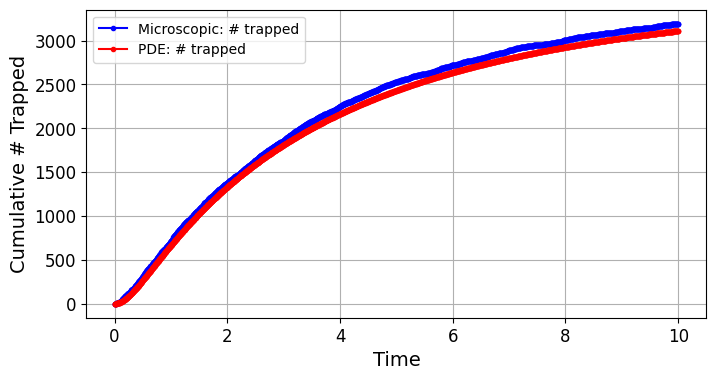

In [3]:
# ---------------------------
# 6. Comparison: "Trapped vs. Time"
# ---------------------------
plt.figure(figsize=(8,4))
plt.plot(t_array, trapped_microscopic, 'b.-', label='Microscopic: # trapped')
plt.plot(times, trapped_pde, 'r.-', label='PDE: # trapped')
# Set axis labels with font size
plt.xlabel("Time", fontsize=14)
plt.ylabel("Cumulative # Trapped", fontsize=14)
#plt.title("Comparison of Trapped Mosquitoes in Microscopic vs PDE")
# Change font size of axis ticks
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)
plt.legend()
# Save the figure to a file
output_file = "/content/trap1D_plot.png"
plt.savefig(output_file, dpi=300, bbox_inches='tight')
print(f"Figure saved to {output_file}")

plt.show()

# Animation

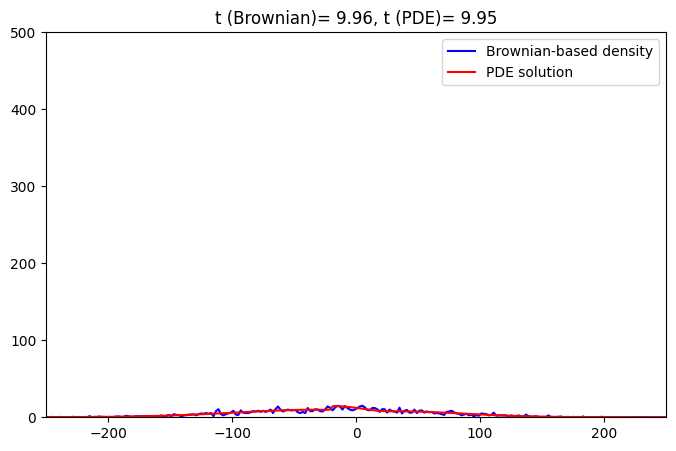

In [ ]:
# ---------------------------
# 5. Animation: PDE vs Microscopic
# ---------------------------

def find_closest_index(array, value):
    """
    Returns the index i in `array` that minimizes |array[i] - value|.
    """
    return np.argmin(np.abs(array - value))


fig_anim, ax_anim = plt.subplots(figsize=(8, 5))
line_brownian, = ax_anim.plot([], [], 'b-', label='Brownian-based density')
line_pde,       = ax_anim.plot([], [], 'r-', label='PDE solution')
title_anim = ax_anim.set_title("")
ax_anim.set_xlim(-x_max/2, x_max/2)
ax_anim.set_ylim(0, 0.05 * N0)
ax_anim.legend()

# The number of frames in the animation will be the same as the microscopic frames
# since we will "look up" the PDE solution index that is closest in time:
num_frames = len(save_positions)

def init_anim():
    line_brownian.set_data([], [])
    line_pde.set_data([], [])
    title_anim.set_text("")
    return line_brownian, line_pde

def update_anim(frame):
    # --- 1) Brownian (microscopic) data at frame ---
    # time_points[frame] is the microscopic time
    tmicro = time_points[frame]
    data = save_positions[frame]
    counts, _ = np.histogram(data, bins=grid_edges)
    density_brownian = counts / dx_hist
    line_brownian.set_data(grid_centers, density_brownian)

    # --- 2) Find the PDE index i_pde that is closest to tmicro ---
    i_pde = find_closest_index(times, tmicro)

    # Get PDE solution at that index
    U_pde = numerical_solution[i_pde, :]
    line_pde.set_data(xx, U_pde)

    # --- 3) Update the title with both times ---
    title_anim.set_text(f"t (Brownian)= {tmicro:.2f}, t (PDE)= {times[i_pde]:.2f}")
    return line_brownian, line_pde

anim2 = FuncAnimation(
    fig_anim, update_anim,
    frames=num_frames,
    init_func=init_anim,
    blit=True,
    interval=150
)

from IPython.display import HTML
HTML(anim2.to_html5_video())  # Uncomment if in Jupyter

# If you want to save the animation as an mp4 file:
anim2.save("comparison_animation.mp4", writer="ffmpeg", fps=5, dpi=150)
